In [1]:
# I Stimulated a 1,500 participants enrolled in a clinical trial.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
)
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
# synthetic features and labels are generated using sklearn's make_classification

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=1500,          # number of participants
    n_features=14,           # number of continuous/categorical variables
    n_informative=8,         # variables that truly influence dropout
    n_redundant=3,           # correlated ones
    n_repeated=0,            # repeated variables
    n_classes=2,             # 1 = dropout, 0 = completed
    weights=[0.7, 0.3],      # dropout rate ≈ 30%
    flip_y=0.02,             # small random label noise
    class_sep=1.0,
    random_state=42
)

In [5]:
#Create a DataFrame with realistic clinical trial column names i found doing research
columns = ["age", "sex", "race", "BMI", "baseline_lab_score", "disease_severity",
 "prior_treatments", "visit1_symptom_score", "visit1_adherence_rate",
    "visit1_AE_count", "visit2_symptom_score", "visit2_adherence_rate",
    "visit2_AE_count", "missed_appointments"]

df = pd.DataFrame(X, columns=columns)

In [6]:
# transformations the data to be more realistic like a real world dataset

# Participant IDs is generated for the length of the rows(1,500)
df['participant_id'] = ['P' + str(i).zfill(4) for i in range(1, len(df)+1)]

# Demographics

#df['age'] is multiplied by 10  to spread values over 10 years
# The addition of 50 shifts the center of the age to middle-aged adults
#.astype(int) converts to integer years

df['age'] = (df['age'] * 10 + 50).astype(int)  # roughly 20–80

#Original df['sex'] is numeric
#This code converts the >0 to female and everything else will be male
df['sex'] = np.where(df['sex'] > 0, 'Female', 'Male')


#df['race'] started as a continuous numeric variable
#np.select maps numeric ranges to category labels

df['race'] = np.select([df['race'] < -0.5,(df['race'] >= -0.5) & (df['race'] < 0.5),
    df['race'] >= 0.5],['White', 'Black', 'Asian'],default='Other')

# Clinical & behavioral variables
df['BMI'] = np.clip(df['BMI'] * 5 + 25, 15, 40)
df['baseline_lab_score'] = np.clip(df['baseline_lab_score'] * 15 + 100, 50, 200)
df['disease_severity'] = np.clip((df['disease_severity'] * 2 + 5), 1, 10).round(1)
df['prior_treatments'] = np.clip((df['prior_treatments'] * 2 + 2).round(), 0, 8).astype(int)

# Visit-related metrics
df['visit1_symptom_score'] = np.clip(df['visit1_symptom_score'] * 5 + 50, 20, 100)
df['visit1_adherence_rate'] = np.clip(df['visit1_adherence_rate'] * 0.1 + 0.85, 0, 1).round(2)
df['visit1_AE_count'] = np.clip((df['visit1_AE_count'] * 1.5 + 2).round(), 0, 8).astype(int)

df['visit2_symptom_score'] = np.clip(df['visit2_symptom_score'] * 5 + 50, 20, 100)
df['visit2_adherence_rate'] = np.clip(df['visit2_adherence_rate'] * 0.1 + 0.80, 0, 1).round(2)
df['visit2_AE_count'] = np.clip((df['visit2_AE_count'] * 1.5 + 2).round(), 0, 8).astype(int)

# Missed appointments (integer)
df['missed_appointments'] = np.clip((df['missed_appointments'] * 1.5 + 1).round(), 0, 6).astype(int)

# Communication score — engagement / satisfaction proxy
np.random.seed(42)
df['communication_score'] = np.random.randint(1, 6, size=len(df))  # 1–5 scale

# Target variable: dropout (1 = withdrew/lost-to-follow-up)
df['dropout'] = y

# Simulate missing data (10% missingness in some visit features)

missing_cols = [
    'visit1_adherence_rate', 'visit2_adherence_rate',
    'visit1_AE_count', 'visit2_AE_count', 'communication_score']
for col in missing_cols:
    df.loc[df.sample(frac=0.1, random_state=42).index, col] = np.nan

# This code reorders the columns

df = df[[
        'participant_id', 'age', 'sex', 'race', 'BMI', 'baseline_lab_score',
        'disease_severity', 'prior_treatments',
        'visit1_symptom_score', 'visit1_adherence_rate', 'visit1_AE_count',
        'visit2_symptom_score', 'visit2_adherence_rate', 'visit2_AE_count',
        'missed_appointments', 'communication_score', 'dropout']]



In [7]:
#Exploring the data

In [8]:
#check how many missing values in the data

df.isnull().sum()

,0
participant_id,0
age,0
sex,0
race,0
BMI,0
baseline_lab_score,0
disease_severity,0
prior_treatments,0
visit1_symptom_score,0
visit1_adherence_rate,150


In [9]:
#remove participant id index

df = df.drop(columns = 'participant_id')

In [10]:
#as we can see visit1_adherence_rate	, visit1_AE_count, visit2_adherence_rate,visit2_AE_count,communication_score are all missing value
#we will deal with them by using the median imputer

In [11]:
df.head()

,age,sex,race,BMI,baseline_lab_score,disease_severity,prior_treatments,visit1_symptom_score,visit1_adherence_rate,visit1_AE_count,visit2_symptom_score,visit2_adherence_rate,visit2_AE_count,missed_appointments,communication_score,dropout
0,86,Female,White,28.010394,108.130642,2.8,2,39.882408,0.88,6.0,41.071416,0.78,0.0,3,4.0,1
1,90,Female,Asian,31.971045,133.654322,6.6,0,42.296753,0.76,2.0,49.231623,0.97,2.0,0,5.0,0
2,80,Female,Asian,22.219823,112.470640,4.6,0,46.937940,0.79,3.0,55.385081,1.00,2.0,0,3.0,1
3,102,Male,Asian,39.724120,142.004621,4.9,0,54.367147,0.75,2.0,55.501965,1.00,0.0,0,5.0,1
4,82,Male,Asian,28.322278,120.791686,2.2,7,44.643032,0.78,2.0,40.369461,1.00,2.0,0,5.0,1


In [12]:

df.shape

(1500, 16)

In [13]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    1500 non-null   int64  
 1   sex                    1500 non-null   object 
 2   race                   1500 non-null   object 
 3   BMI                    1500 non-null   float64
 4   baseline_lab_score     1500 non-null   float64
 5   disease_severity       1500 non-null   float64
 6   prior_treatments       1500 non-null   int64  
 7   visit1_symptom_score   1500 non-null   float64
 8   visit1_adherence_rate  1350 non-null   float64
 9   visit1_AE_count        1350 non-null   float64
 10  visit2_symptom_score   1500 non-null   float64
 11  visit2_adherence_rate  1350 non-null   float64
 12  visit2_AE_count        1350 non-null   float64
 13  missed_appointments    1500 non-null   int64  
 14  communication_score    1350 non-null   float64
 15  drop

In [14]:
df["sex"] = df["sex"].astype("category")
df["race"] = df["race"].astype("category")
df["dropout"] = df["dropout"].astype("int")


In [15]:
df.describe()

,age,BMI,baseline_lab_score,disease_severity,prior_treatments,visit1_symptom_score,visit1_adherence_rate,visit1_AE_count,visit2_symptom_score,visit2_adherence_rate,visit2_AE_count,missed_appointments,communication_score,dropout
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1350.000000,1350.000000,1500.000000,1350.000000,1350.000000,1500.000000,1350.000000,1500.000000
mean,71.116667,27.540921,104.784091,4.975667,1.278667,48.800314,0.847837,3.557778,50.199201,0.845844,1.884444,1.705333,3.001481,0.305333
std,28.209293,8.337291,27.224454,1.917314,1.951636,8.770197,0.090289,1.900995,9.549063,0.148092,2.044351,1.949625,1.431406,0.460702
min,-21.000000,15.000000,50.000000,1.000000,0.000000,25.308805,0.530000,0.000000,20.000000,0.260000,0.000000,0.000000,1.000000,0.000000
25%,52.000000,20.169819,84.975389,3.600000,0.000000,42.799034,0.780000,2.000000,43.673766,0.750000,0.000000,0.000000,2.000000,0.000000
50%,72.000000,27.439847,105.012746,5.000000,0.000000,48.527239,0.850000,4.000000,50.133845,0.870000,1.000000,1.000000,3.000000,0.000000
75%,89.000000,34.831122,123.478456,6.300000,2.000000,54.591353,0.920000,5.000000,56.804378,0.990000,3.000000,3.000000,4.000000,1.000000
max,163.000000,40.000000,187.657942,10.000000,8.000000,78.611748,1.000000,8.000000,80.946668,1.000000,8.000000,6.000000,5.000000,1.000000


In [16]:
#visit2 values should not exist if visit1 is missing

invalid_rows = df[
    df[["visit1_symptom_score","visit1_adherence_rate","visit1_AE_count"]].isna().all(axis=1) &
    df[["visit2_symptom_score","visit2_adherence_rate","visit2_AE_count"]].notna().any(axis=1)
]
print("Invalid rows:", len(invalid_rows))




Invalid rows: 0


In [17]:
df[df.isna().any(axis=1)]



,age,sex,race,BMI,baseline_lab_score,disease_severity,prior_treatments,visit1_symptom_score,visit1_adherence_rate,visit1_AE_count,visit2_symptom_score,visit2_adherence_rate,visit2_AE_count,missed_appointments,communication_score,dropout
15,55,Female,White,26.007635,118.488106,5.4,1,43.229804,NaN,NaN,49.055886,NaN,NaN,0,NaN,1
23,44,Male,White,34.832250,108.492301,3.8,7,60.041054,NaN,NaN,45.912689,NaN,NaN,1,NaN,0
29,69,Female,Asian,17.678464,70.533374,7.0,0,50.089954,NaN,NaN,52.421594,NaN,NaN,1,NaN,0
44,98,Male,White,37.030781,140.395173,6.2,3,46.364192,NaN,NaN,55.381561,NaN,NaN,3,NaN,1
49,47,Male,Asian,15.000000,108.343335,5.4,5,37.450156,NaN,NaN,43.490526,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,46,Female,Asian,27.444597,86.733178,4.6,3,57.860527,NaN,NaN,37.962874,NaN,NaN,0,NaN,0
1470,117,Male,Black,38.051646,86.969447,2.1,0,61.472663,NaN,NaN,55.299246,NaN,NaN,6,NaN,0
1473,51,Male,White,15.000000,86.060162,3.6,1,35.463541,NaN,NaN,34.262788,NaN,NaN,0,NaN,1
1490,94,Male,Black,33.939688,122.952164,2.7,0,47.842414,NaN,NaN,54.947623,NaN,NaN,3,NaN,1


In [18]:
df.isna().sum()

,0
age,0
sex,0
race,0
BMI,0
baseline_lab_score,0
disease_severity,0
prior_treatments,0
visit1_symptom_score,0
visit1_adherence_rate,150
visit1_AE_count,150


For a subset of approximately 150 participants, symptom scores were recorded at both Visit 1 and Visit 2, but associated adherence, adverse event, and engagement fields were missing. Because the presence of symptom scores indicates that the visits took place, these cases were treated as partial missingness rather than as absent visits.

For these variables, we created binary missingness indicators and imputed the underlying numeric values using median imputation within the preprocessing pipeline. This approach preserves available clinical information, avoids fabricating entire visits, and allows the model to learn from patterns of incomplete operational data, which may themselves be associated with dropout risk.

In [19]:

(df['age'] < 18).value_counts()



,count
age,
False,1451
True,49


In [20]:
(df['age'] > 90).value_counts()

,count
age,
False,1141
True,359


EDA showed some implausible ages (<18 and >90). Because this study assumes adult participants, ages were constrained to a clinically plausible adult range (18–90). Values outside this range were treated as data artifacts and capped to preserve sample size and maintain realism.


In [21]:
df[['sex']].value_counts()

,count
sex,
Male,759
Female,741


Sex is reasonably balanced, which reduces the risk that model performance is driven by a heavily skewed demographic subgroup.

In [22]:
df[['race']].value_counts()

,count
race,
Asian,619
White,572
Black,309


Multiple race categories are represented. This supports subgroup checking during evaluation and encourages fairness-aware interpretation when discussing drivers of dropout.


In [23]:
df[['dropout']].value_counts()

,count
dropout,
0,1042
1,458


shows approximately 30.5% dropout rate

In [24]:
#store the categorical and numerical variable
cat_cols = ['sex','race']

num_cols = ['age', 'BMI', 'baseline_lab_score', 'disease_severity', 'prior_treatments',
 'visit1_symptom_score', 'visit1_adherence_rate', 'visit1_AE_count',
 'visit2_symptom_score', 'visit2_adherence_rate', 'visit2_AE_count',
 'missed_appointments', 'communication_score']

Age distribution

1. Is our sample skews towards older or younger?

2. Does our trial mostly includes geriatric participants?(common in chronic disease trials).



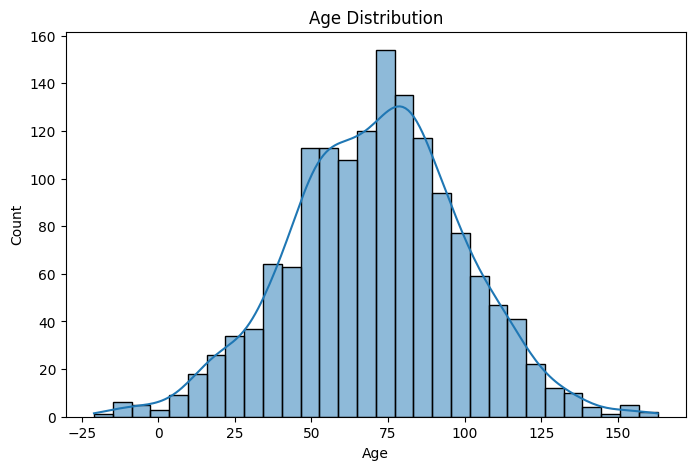

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


Sex distribution

Are males and females evenly represented?

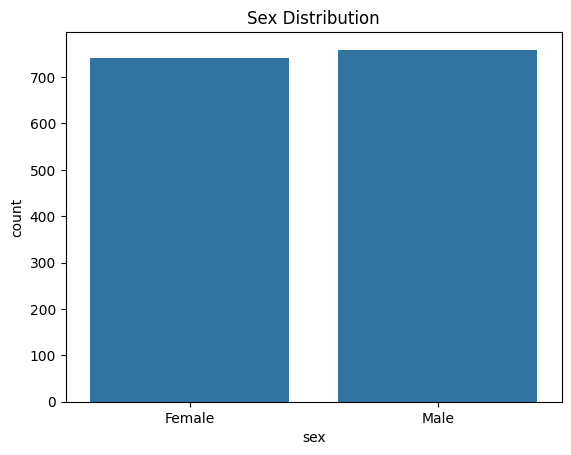

In [26]:
sns.countplot(data= df, x='sex')
plt.title("Sex Distribution")
plt.show()


Why it matters:
Sex-based differences can influence:

adherence

side effects

dropout tendencies

How to interpret:

If one sex dominates (e.g., 70% female), check dropout bias.

Race distribution

is our study population  diverse?

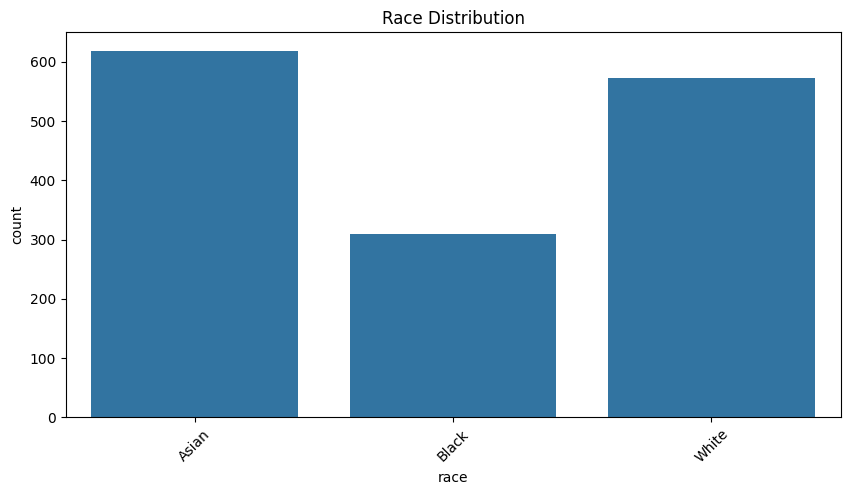

In [27]:
#view race distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='race')
plt.title("Race Distribution")
plt.xticks(rotation=45)
plt.show()


Why it matters:
Certain racial groups may have:

different socioeconomic barriers

different AE reporting patterns

cultural differences in retention

Interpretation:
If any group shows higher dropout proportion, you must check for fairness issues later.

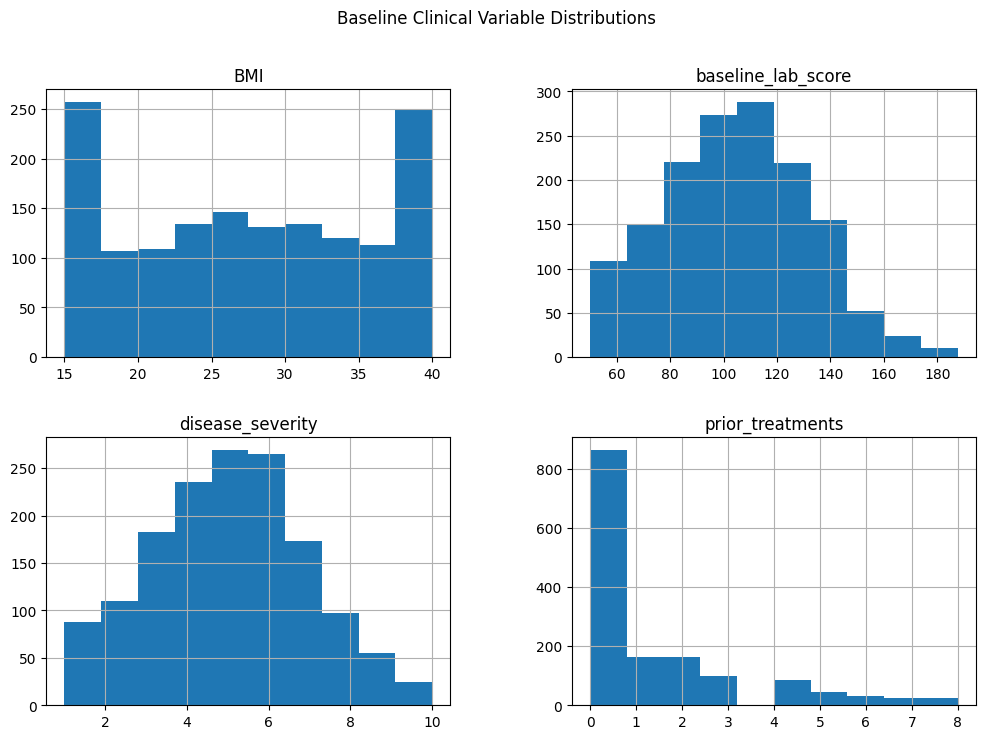

In [28]:
num_vars_of_interest = ['BMI', 'baseline_lab_score', 'disease_severity', 'prior_treatments'
]

df[num_vars_of_interest].hist(figsize=(12,8))
plt.suptitle("Baseline Clinical Variable Distributions")
plt.show()

BMI, baseline lab score, disease severity, and prior treatments fall into plausible ranges for a chronic-disease style trial. These baseline variables capture overall health burden that can influence adherence, adverse events, and retention.

Visit 1 & Visit 2 Analysis

Compare symptom score changes

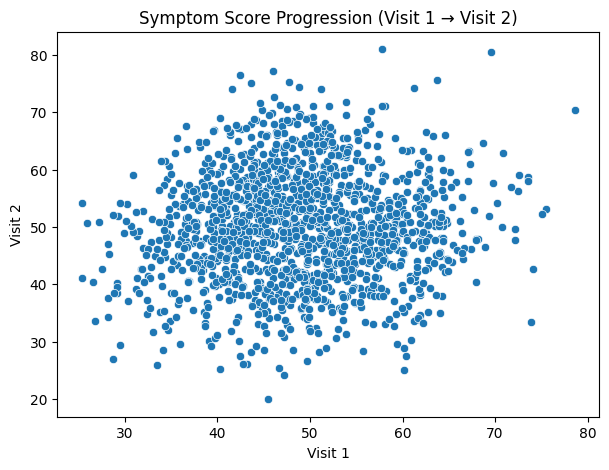

In [29]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=df['visit1_symptom_score'], y=df['visit2_symptom_score'])
plt.title("Symptom Score Progression (Visit 1 → Visit 2)")
plt.xlabel("Visit 1")
plt.ylabel("Visit 2")
plt.show()


Most participants carry a similar level of symptom severity from Visit 1 into Visit 2, but individual trajectories vary. Early symptom scores provide useful information, yet they must be combined with other clinical and behavioral factors to fully understand participant outcomes.

**Adherence distribution**

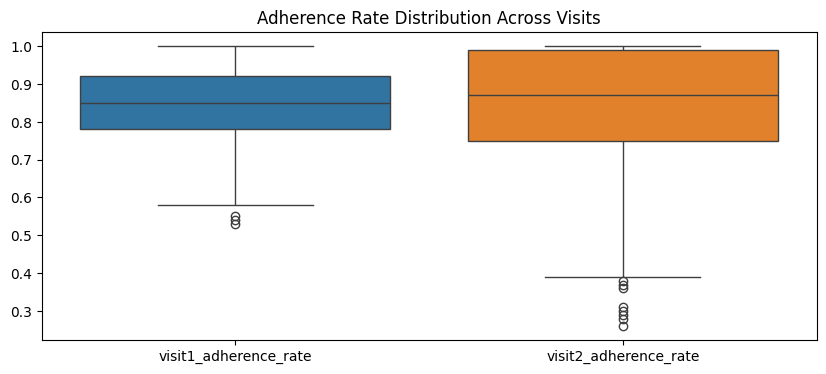

In [30]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df[['visit1_adherence_rate','visit2_adherence_rate']] )
plt.title("Adherence Rate Distribution Across Visits" )
plt.show()


This boxplot compares adherence rates between Visit 1 and Visit 2.
Overall adherence remains high at both visits, with similar median values, indicating that most participants initially follow the study protocol well.

However, Visit 2 shows greater variability and more low-adherence outliers, suggesting that adherence becomes more inconsistent as the trial progresses.

This pattern highlights adherence as an important early warning signal, since declining or unstable adherence may increase the risk of participant dropout.

**Engagement Behavior**

Missed appointments vs dropout

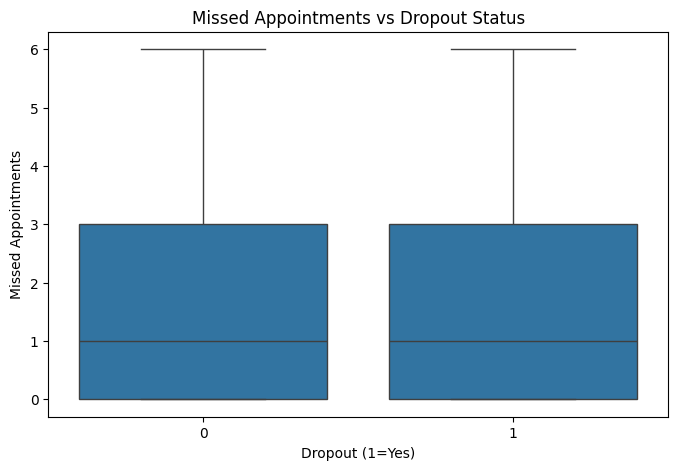

In [31]:
plt.figure(figsize=(8,5) )
sns.boxplot(x='dropout', y='missed_appointments', data=df)
plt.title("Missed Appointments vs Dropout Status")
plt.xlabel("Dropout (1=Yes)" )
plt.ylabel("Missed Appointments")
plt.show( )


The median number of missed appointments is the same for both groups (around 1).

The interquartile range (middle 50%) is nearly identical, spanning roughly 0 to 3 missed appointments.

The minimum and maximum values are also very similar, with both groups reaching up to about 6 missed appointments.

Based on this visualization alone, missed appointments do not clearly differentiate dropouts from non-dropouts.

Communication score vs dropout


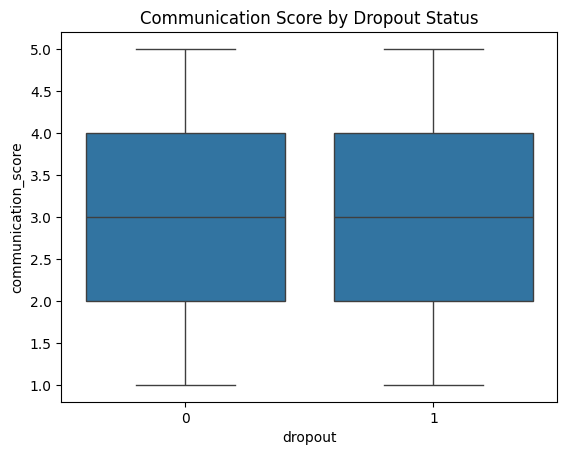

In [32]:
sns.boxplot(x='dropout', y='communication_score', data=df )
plt.title("Communication Score by Dropout Status" )
plt.show()


There is no visible difference in communication scores between participants who dropped out and those who completed the trial.

The two distributions completely overlap, indicating that communication score alone does not distinguish dropout behavior in this dataset.



Dropout Analysis

Dropout ratio

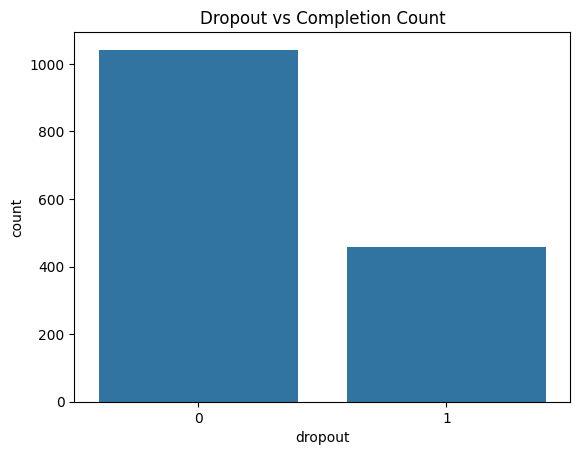

,proportion
dropout,
0,0.694667
1,0.305333


In [33]:
sns.countplot( x='dropout', data=df)
plt.title("Dropout vs Completion Count")
plt.show()

df['dropout' ].value_counts(normalize=True)


The target variable shows that dropout is the minority class. Class imbalance motivates careful metric selection (ROC-AUC/PR-AUC, precision, recall) and the use of imbalance-handling techniques during training.

**Other EDA worth considering**

Dropout by demographic groups

In [34]:
pd.crosstab(df['sex' ], df['dropout'], normalize='index' )


dropout,0,1
sex,,
Female,0.695007,0.304993
Male,0.694335,0.305665


Male and Women have similar chances of dropping out

In [35]:
pd.crosstab( df['race'], df['dropout'], normalize='index')


dropout,0,1
race,,
Asian,0.823910,0.176090
Black,0.763754,0.236246
White,0.517483,0.482517


In [36]:
# Define age bins and corresponding labels
age_bins = [0, 20, 40, 60, 80, 200]
age_labels = ["0–20", "21–40", "41–60", "61–80", "81+"]

# Categorize ages into defined groups
df["age_group"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True)

# This calculates the average dropout rate by age group
dropout_by_age = df.groupby("age_group")["dropout"].mean()
print(dropout_by_age)

# Count how many records fall into each age group
counts_by_age = df["age_group"].value_counts().sort_index()
print(counts_by_age)


age_group
0–20     0.192308
21–40    0.226277
41–60    0.236364
61–80    0.319693
81+      0.369792
Name: dropout, dtype: float64
age_group
0–20      52
21–40    137
41–60    330
61–80    391
81+      576
Name: count, dtype: int64


In [37]:
df[num_cols].corr()
#This is a correlation matrix of the numerical predictor variables

,age,BMI,baseline_lab_score,disease_severity,prior_treatments,visit1_symptom_score,visit1_adherence_rate,visit1_AE_count,visit2_symptom_score,visit2_adherence_rate,visit2_AE_count,missed_appointments,communication_score
age,1.000000,0.426953,0.333872,0.019890,-0.335841,-0.242550,-0.035101,0.151397,-0.184636,0.403363,-0.514875,0.416097,0.004368
BMI,0.426953,1.000000,0.653933,0.000017,-0.058540,0.393686,-0.008045,0.202638,-0.067502,0.221445,0.088556,0.522657,-0.037887
baseline_lab_score,0.333872,0.653933,1.000000,-0.005961,0.145781,-0.227352,0.018689,-0.015384,0.056045,0.161652,0.211787,-0.057076,-0.009786
disease_severity,0.019890,0.000017,-0.005961,1.000000,-0.028120,0.003948,0.000900,0.021627,-0.021402,0.007779,-0.020923,-0.005489,-0.012042
prior_treatments,-0.335841,-0.058540,0.145781,-0.028120,1.000000,-0.061981,0.011287,0.010842,-0.172921,0.173783,0.078690,-0.149874,0.019487
visit1_symptom_score,-0.242550,0.393686,-0.227352,0.003948,-0.061981,1.000000,0.005404,0.181200,0.071042,0.046952,0.085187,0.381520,-0.032763
visit1_adherence_rate,-0.035101,-0.008045,0.018689,0.000900,0.011287,0.005404,1.000000,-0.024321,0.025185,0.009717,0.038845,-0.019586,-0.042993
visit1_AE_count,0.151397,0.202638,-0.015384,0.021627,0.010842,0.181200,-0.024321,1.000000,0.104395,0.133340,-0.032615,0.255473,0.048187
visit2_symptom_score,-0.184636,-0.067502,0.056045,-0.021402,-0.172921,0.071042,0.025185,0.104395,1.000000,0.083372,0.393173,-0.099955,0.021699
visit2_adherence_rate,0.403363,0.221445,0.161652,0.007779,0.173783,0.046952,0.009717,0.133340,0.083372,1.000000,0.002649,0.073606,-0.014169


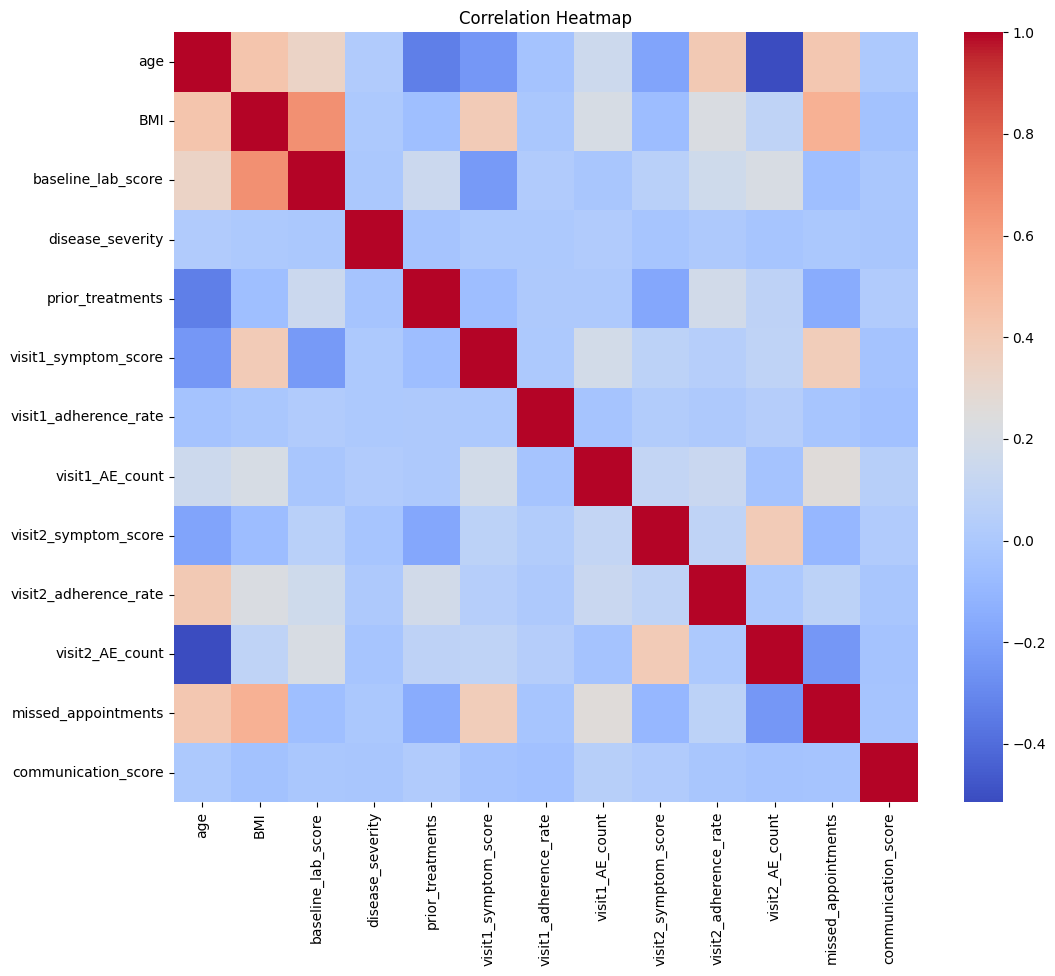

In [38]:
#Plot showing the corr matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()




Strongest positive relationship: BMI and baseline_lab_score (r = 0.654) — higher BMI tends to align with higher baseline lab scores.

Missed appointments are linked to baseline/early signals: missed_appointments correlates with BMI (0.523), age (0.416), and visit1_symptom_score (0.382), suggesting participants with higher BMI/older age/higher early symptoms tend to miss more visits.

Symptoms don’t “carry over” strongly between visits: visit1_symptom_score vs visit2_symptom_score is weak (0.071), meaning Visit 1 symptoms alone don’t linearly predict Visit 2 symptoms in this dataset.


Strongest negative relationship: age vs visit2_AE_count (−0.515) — older participants tend to have fewer Visit 2 adverse events.

Disease severity and communication score show near-zero correlations with most variables, meaning they don’t have strong linear relationships with the other features here.

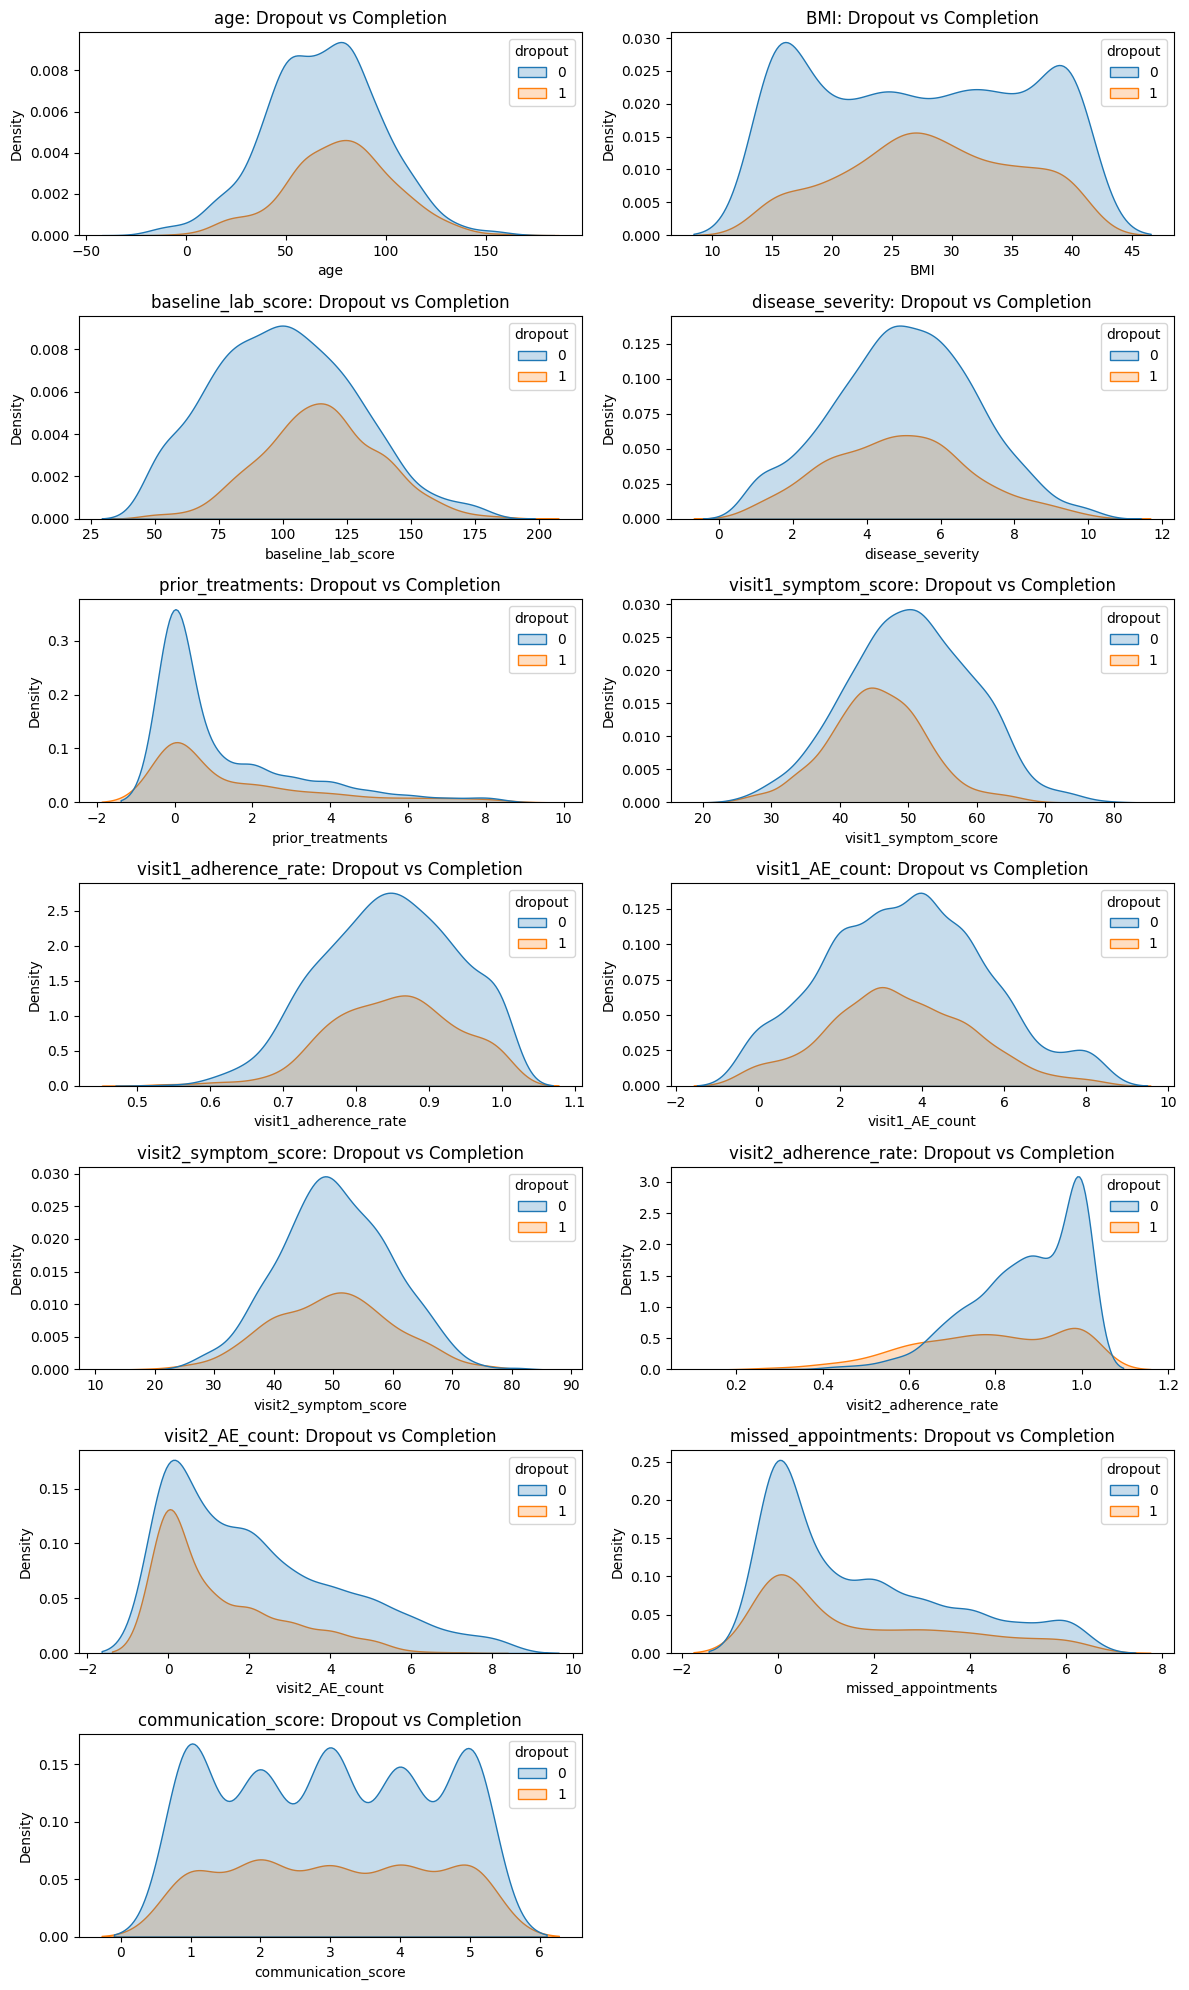

In [39]:


plt.figure(figsize=(12,20))
for i, col in enumerate(num_cols, 1):
    plt.subplot(7,2,i)
    sns.kdeplot(data=df, x=col, hue="dropout", fill=True)
    plt.title(f"{col}: Dropout vs Completion")
plt.tight_layout()
plt.show()


**SUMMARY OF EDA**


**Purpose:**
The goal of this EDA is to assess data quality, look for pattern, understand feature distributions, evaluate class balance, and identify relationships between predictors and the dropout outcome.


**What patterns I found**

Age:
Most participants were older adults, which makes sense for this type of trial. Age alone did not clearly explain who dropped out.

Sex and race:
These were fairly balanced. No group clearly dropped out more just because of sex or race.

Baseline health (BMI, lab score, disease severity):
People who dropped out and people who completed the trial looked very similar at the start.
- This means starting health condition alone does not explain dropout.

Symptoms over time:
People with worse symptoms at Visit 1 usually still had worse symptoms at Visit 2.

Adherence (how well people followed the study):
Adherence started high but dropped for some people by Visit 2.
- This was one of the strongest early warning signs of dropout.

Missed appointments & communication:
These did not clearly separate dropouts by themselves, but when combined with other behaviors, they helped show disengagement.

Dropout outcome:
Fewer people dropped out than completed the trial.
- This means the data is imbalanced.

**Problems I found in the data**

Some ages were too young or unrealistically high

Some visit data was missing

Dropouts were less common than completers

Some variables were related to each other

**How I fixed the problems**

I limited ages to a realistic adult range instead of deleting people.

I kept missing data and added flags so the model could learn from it.

I used better evaluation metrics instead of accuracy only.

I used machine learning models that handle related variables well.

**Main takeaway**

People don’t drop out mainly because of who they are or how sick they are at the start.
They drop out because of behavior over time, especially:

Lower adherence

Missed visits

Signs of disengagement

That’s why a machine learning model that looks at many features together works better than simple rules.

**Data** **Preparation**

**Imports for modeling**

In [40]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    average_precision_score, precision_recall_curve)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt
import joblib


This code below is creating a custom scikit-learn transformer

   Why make a custom transformer?
    - Because these rules follows clinical protocol rules"
      that must happen the same way every time (train, test, production app).
    - Creating this will make the model adjust to new data with the same issues instead of breaking the code.
    - Putting them inside the pipeline prevents data leakage and inconsistency.

In [45]:


class ClinicalConsistencyTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, age_col="age", min_age=18, max_age=90):
        # Store user-defined settings so they can be reused consistently
        self.age_col = age_col
        self.min_age = min_age
        self.max_age = max_age

        # Explicit list of Visit 1 columns used to detect whether Visit 1 happened
        self.visit1_cols = ["visit1_symptom_score","visit1_adherence_rate","visit1_AE_count"]

        # Explicit list of Visit 2 columns that must not exist if Visit 1 doesn't exist
        self.visit2_cols = ["visit2_symptom_score", "visit2_adherence_rate", "visit2_AE_count"]

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        #copying the data to avoid modifying the original DataFrame
        X = X.copy()
        # 1) Age cleaning
        # Apply the age rules if the age column exists.
        if self.age_col in X.columns:

            # Any age lower than min_age is replaced with min_age.
            X.loc[X[self.age_col] < self.min_age, self.age_col] = self.min_age
            # Any age higher than max_age is replaced with max_age.
            X.loc[X[self.age_col] > self.max_age, self.age_col] = self.max_age
        # 2) Visit consistency logic
        # Only run visit logic if *all* required visit columns exist in the dataset.
        # This prevents crashes if a column is missing in some environment.
        if all(col in X.columns for col in self.visit1_cols + self.visit2_cols):

            # Build a row-level mask:
            # True when *every* Visit 1 column is NaN in that row.
            # Meaning: "Visit 1 never happened / no data for Visit 1"
            no_visit1_mask = X[self.visit1_cols].isna().all(axis=1)

            # For rows where Visit 1 is completely missing,
            # wipe out Visit 2 columns by setting them to NaN bc it's clinically impossible to have Visit 2 data if Visit 1
            # has no recorded data at all (timeline/protocol consistency).
            # IMPORTANT BEHAVIOR:
            # If even ONE Visit 1 value exists, Visit 2 is left as-is.
            X.loc[no_visit1_mask, self.visit2_cols] = np.nan
        # Return the cleaned, protocol-consistent dataset.
        return X

class MissingIndicatorAdder(BaseEstimator, TransformerMixin):
    """Adds *_missing indicator columns (0/1) for selected columns.

    NOTE: Keep constructor clone-safe (do not modify params here).
    """

    def __init__(self, columns):
        self.columns = columns  # do NOT wrap with list() here

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[f"{col}_missing"] = X[col].isna().astype(int)
        return X

**Custom Transformer Summary**

Enforces basic clinical trial rules to keep the data realistic and consistent.

Corrects implausible ages by restricting participants to an adult range (18–90) without discarding records.

Ensures visit timeline consistency by removing Visit 2 data when Visit 1 data is entirely missing.

Adds missing-value indicator flags for key variables so the model can learn whether missingness itself is informative.

Applies the same transformations during both training and deployment, ensuring stable and reliable predictions.

**Define X / y, split train/test (drop ID if present)**

In [46]:
target_col = "dropout"
id_cols = [c for c in ["participant_id"] if c in df.columns]
#split the data into train and test sets.
#80% will be for train, 20% will be for test
X = df.drop(columns=[target_col] + id_cols, errors="ignore")
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Feature groups + preprocessors**

In [47]:

base_numeric_features = ["age","BMI","baseline_lab_score","disease_severity","prior_treatments",
    "visit1_symptom_score","visit1_adherence_rate","visit1_AE_count",
    "visit2_symptom_score","visit2_adherence_rate","visit2_AE_count",
    "missed_appointments","communication_score"]

categorical_features = ["sex","race"]

cols_with_partial_missing = ["visit1_adherence_rate","visit1_AE_count",
    "visit2_adherence_rate","visit2_AE_count",
    "missed_appointments","communication_score"]
#Automatically creates new column names such as: visit1_adherence_rate_missing

missing_indicator_cols = [c + "_missing" for c in cols_with_partial_missing]

#Builds the final numeric feature list used by the model.
#Actual measured values and Binary missingness signals

numeric_features = base_numeric_features + missing_indicator_cols

#imputes with median
#Robust to outliers (common in labs, counts, adherence).
#Clinically safer than mean for skewed data.
#scaler scales the data converts mean = 0, sd = 1

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

#Converts categories into binary columns
#handle_unknown="ignore": Prevents crashes in production if a new category appears.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))])
#Numeric pipeline to numeric columns, Numeric pipeline to numeric columns
#Drops anything not explicitly listed
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop")





**Pipelines: Logistic Regression, Random Forest, XGBoost**

In [48]:
#Uses ImbPipeline (from imblearn) instead of scikit-learn’s Pipeline
#Required because SMOTE changes the sample size.

common_steps = [
    ("clinical_logic", ClinicalConsistencyTransformer(min_age=18, max_age=90)),
    ("missing_flags", MissingIndicatorAdder(columns=cols_with_partial_missing)),
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
]
#Strong baseline model for clinical prediction.
lr_pipeline = ImbPipeline(steps=common_steps + [
    ("model", LogisticRegression(max_iter=2000))
])
#Captures non-linear relationships
rf_pipeline = ImbPipeline(steps=common_steps + [
    ("model", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

#Often state-of-the-art for tabular clinical data
xgb_pipeline = ImbPipeline(steps=common_steps + [
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])


**Baseline comparison (CV ROC-AUC only)**

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_roc_auc(name, pipe):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{name} CV ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean()

lr_cv = cv_roc_auc("LogReg", lr_pipeline)
rf_cv = cv_roc_auc("RandomForest", rf_pipeline)
xgb_cv = cv_roc_auc("XGBoost", xgb_pipeline)


LogReg CV ROC-AUC: 0.8056 ± 0.0253
RandomForest CV ROC-AUC: 0.9353 ± 0.0123
XGBoost CV ROC-AUC: 0.9412 ± 0.0125


ROC-AUC measures how well a model separates dropouts from completers across all possible probability thresholds.

A value of:

0.50 = no better than random guessing

0.70–0.80 = acceptable

0.80–0.90 = strong

Greater than 0.90 = excellent (rare in messy clinical data)

The ± value is the standard deviation across CV folds, which reflects stability and generalizability.

XGBoost performed best, so we proceed with tuning + deeper evaluation.

**Tune XGBoost (RandomizedSearchCV) before final fit**

RandomizedSearchCV is a tool that automatically tunes a model’s hyperparameters by trying random combinations of settings and keeping the one that performs best under cross-validation.

In [50]:
#These values were implemented based on my research from xgboost documentation and other valueable resources
#xgboost is a tree based model so this works perfectly for it
xgb_param_dist = {
# How many trees to build (more trees can help, but takes longer)
    "model__n_estimators": [200, 400, 800],

    # How deep each tree can grow (deeper = more complex, overfitting risk)
    "model__max_depth": [3, 4, 5, 6],

    # Step size for boosting (smaller = slower learning, often more stable)
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],

    # Row sampling per tree (adds randomness, helps generalization)
    "model__subsample": [0.7, 0.8, 0.9, 1.0],

    # Feature sampling per tree (reduces reliance on a few predictors)
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],

    # Minimum "weight"/data needed to make a split (higher = more conservative)
    "model__min_child_weight": [1, 3, 5],

    # Minimum improvement needed to create a split (higher = fewer unnecessary splits)
    "model__gamma": [0, 0.1, 0.2],
}


xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,               # chosen pipeline
    param_distributions=xgb_param_dist,   # tunings
    n_iter=30,                            # how many random combinations to test
    scoring="roc_auc",                    # metric to optimize
    cv=cv,                                # stratified 5-fold CV you created earlier
    random_state=42,                      # reproducible results
    n_jobs=-1,                            # speeds the runtime
    verbose=1 )                            # prints current results while actively running

xgb_search.fit(X_train, y_train)

print("Best XGB params:", xgb_search.best_params_)
print("Best CV ROC-AUC:", xgb_search.best_score_)

final_xgb_pipeline = xgb_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB params: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__min_child_weight': 1, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__gamma': 0.1, 'model__colsample_bytree': 1.0}
Best CV ROC-AUC: 0.940967557487052


**Final test evaluation (XGBoost)**

In [51]:
final_xgb_pipeline.fit( X_train, y_train)

y_pred_xgb = final_xgb_pipeline.predict(X_test )
y_proba_xgb = final_xgb_pipeline.predict_proba(X_test)[:, 1]

print( "Final XGBoost (Test)")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, zero_division=0))
print("Recall:", recall_score( y_test, y_pred_xgb, zero_division=0 ))
print("F1:", f1_score(y_test, y_pred_xgb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test,  y_proba_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n",  classification_report(y_test, y_pred_xgb, zero_division=0))


Final XGBoost (Test)
Accuracy: 0.92
Precision: 0.8695652173913043
Recall: 0.8695652173913043
F1: 0.8695652173913043
ROC-AUC: 0.9611204013377926

Confusion Matrix:
 [[196  12]
 [ 12  80]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       208
           1       0.87      0.87      0.87        92

    accuracy                           0.92       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.92      0.92      0.92       300



**PR-AUC + threshold tuning (XGBoost)**


PR-AUC (Average Precision): 0.9390


,threshold,precision,recall,f1
9,0.50,0.869565,0.869565,0.869565
8,0.45,0.869565,0.869565,0.869565
7,0.40,0.836735,0.891304,0.863158
11,0.60,0.914634,0.815217,0.862069
10,0.55,0.885057,0.836957,0.860335
6,0.35,0.788462,0.891304,0.836735
5,0.30,0.763636,0.913043,0.831683
12,0.65,0.909091,0.760870,0.828402
4,0.25,0.739130,0.923913,0.821256
13,0.70,0.917808,0.728261,0.812121



Chosen threshold (recall ≥ 0.9):
threshold    0.300000
precision    0.763636
recall       0.913043
f1           0.831683
Name: 5, dtype: float64

 FINAL chosen_threshold for Streamlit: 0.30
At this threshold -> Precision=0.764, Recall=0.913, F1=0.832

Confusion Matrix (custom threshold):
 [[182  26]
 [  8  84]]
TN=182, FP=26, FN=8, TP=84

Classification Report (custom threshold):
               precision    recall  f1-score   support

           0       0.96      0.88      0.91       208
           1       0.76      0.91      0.83        92

    accuracy                           0.89       300
   macro avg       0.86      0.89      0.87       300
weighted avg       0.90      0.89      0.89       300



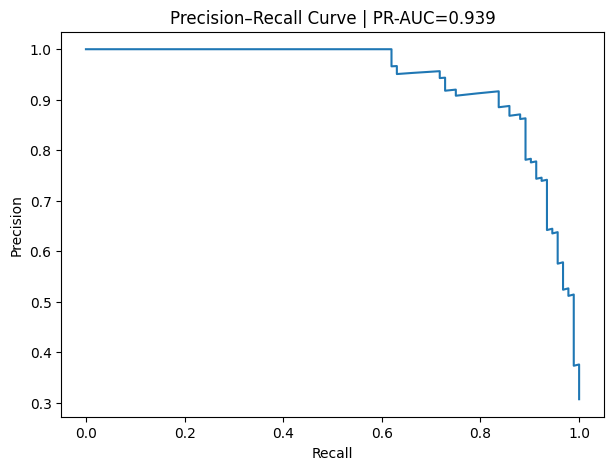

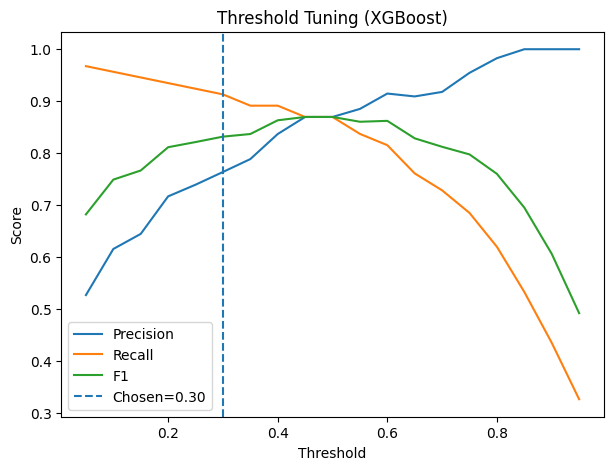

In [52]:
# PR-AUC (Average Precision)
pr_auc_xgb = average_precision_score(y_test, y_proba_xgb)
print(f"\nPR-AUC (Average Precision): {pr_auc_xgb:.4f}")

# Threshold sweep
#using a threshold value (probability cutoff)from 0.05 to 0.95 with an increment of 0.05

thresholds = np.arange(0.05, 0.96, 0.05)
rows = []
for t in thresholds:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
    })

thr_table = pd.DataFrame(rows)
display(thr_table.sort_values("f1", ascending=False).head(10))

# Choose threshold: recall target first, else best F1
target_recall = 0.90
candidates = thr_table[thr_table["recall"] >= target_recall]

if len(candidates) > 0:
    best_row = candidates.sort_values(["precision", "f1"], ascending=False).iloc[0]
    chosen_threshold = float(best_row["threshold"])
    print(f"\nChosen threshold (recall ≥ {target_recall}):")
else:
    best_row = thr_table.loc[thr_table["f1"].idxmax()]
    chosen_threshold = float(best_row["threshold"])
    print("\nChosen threshold (best F1):")

print(best_row)


print(f"\n FINAL chosen_threshold for Streamlit: {chosen_threshold:.2f}")
print(
    f"At this threshold -> Precision={best_row['precision']:.3f}, "
    f"Recall={best_row['recall']:.3f}, F1={best_row['f1']:.3f}"
)

# Evaluate with chosen threshold
y_pred_custom = (y_proba_xgb >= chosen_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_custom)
print("\nConfusion Matrix (custom threshold):\n", cm)


tn, fp, fn, tp = cm.ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nClassification Report (custom threshold):\n",
      classification_report(y_test, y_pred_custom, zero_division=0))

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve | PR-AUC={pr_auc_xgb:.3f}")
plt.show()

# Threshold tradeoff plot (Precision/Recall/F1 vs threshold)
plt.figure(figsize=(7,5))
plt.plot(thr_table["threshold"], thr_table["precision"], label="Precision")
plt.plot(thr_table["threshold"], thr_table["recall"], label="Recall")
plt.plot(thr_table["threshold"], thr_table["f1"], label="F1")
plt.axvline(chosen_threshold, linestyle="--", label=f"Chosen={chosen_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (XGBoost)")
plt.legend()
plt.show()


**SHAP summary (XGBoost only)**


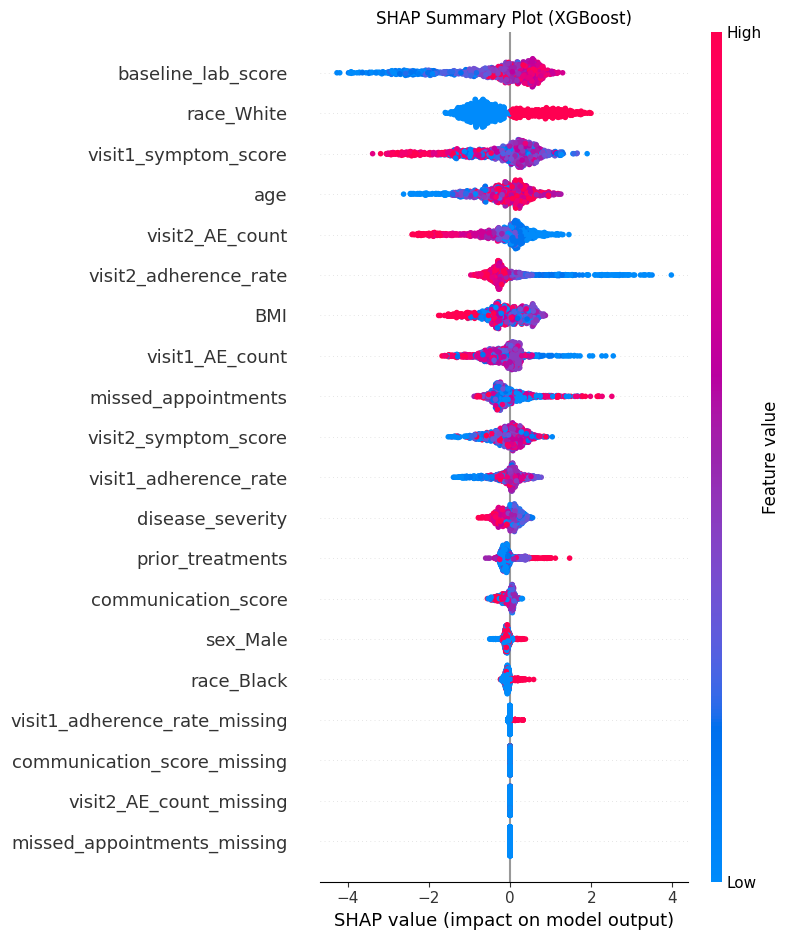

In [53]:
# Get the trained xgb model and the transformed matrix
preprocess = final_xgb_pipeline.named_steps["preprocess"]
model = final_xgb_pipeline.named_steps["model"]
clinical = final_xgb_pipeline.named_steps["clinical_logic"]
flags = final_xgb_pipeline.named_steps["missing_flags"]

X_logic = clinical.transform(X_train)
X_flags = flags.transform(X_logic)
X_prep = preprocess.transform(X_flags)

# Build feature names
num_cols = preprocess.transformers_[0][2]
ohe = preprocess.named_transformers_["cat"].named_steps["encoder"]
cat_cols = ["sex","race"]
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.array(list(num_cols) + list(cat_names), dtype=object)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_prep)

# Plot
shap.summary_plot(shap_values, X_prep, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot (XGBoost)")
plt.tight_layout()
plt.show()


**Save final model pipeline (for Streamlit)**

In [54]:
joblib.dump(final_xgb_pipeline, "xgb_dropout_pipeline.pkl")
print("Saved: xgb_dropout_pipeline.pkl")


Saved: xgb_dropout_pipeline.pkl


In [55]:
from google.colab import files

files.download("xgb_dropout_pipeline.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
import sklearn
import imblearn

print("sklearn version:", sklearn.__version__)
print("imblearn version:", imblearn.__version__)


sklearn version: 1.6.1
imblearn version: 0.14.0
